<a href="https://colab.research.google.com/github/SFStefenon/DamLevelHydroelectric/blob/main/Wavelet-Seq2Seq-LSTM-Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Wavelet-Seq2Seq-LSTM with Attention**

Dr. **Stefano Frizzo Stefenon** and Dr. **Laio Oriel Seman**. 

Trento, Italy, March 10, 2023. 


The model proposed has the following features:

> The wavelet transform makes noise reduction for chaotic time series.

> The seq2seq-LSTM makes predictions based on the history of variation in the dam level of the hydroelectric plant.

> The attention mechanism assigns appropriate weight to each encoder's hidden state output, and maps them to the output sequence, solving the problem of having a weak memory about the previous time steps in a long time series.

Dataset Definition:

> The evaluation can be performed using the wavelet transform or without it from a synthetic or real dataset.

> The number of experiments and epochs has a major influence on the simulation time. We recommend using at least 100 epochs and 50 experiments (when statistical analysis is performed).

In [18]:
# Data type definition
DataSet = 1
# 0 = Synthetic data
# 1 = Hidroeletric data

# Definition about the use of wavelet transform
WaveletUse = 0
# Wavelet not use = 0
# Wavelet use = 1

# Number of experiments to perform a statistical analysis
Experiments = 1
# Number of epochs
epc = 100

# Import Libraries

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.core.framework.types_pb2 import DataType

import pandas as pd
from keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model
import time
import os 

from skimage.restoration import denoise_wavelet

!pip install -q phik
import phik
from phik import resources, report

# Load the Dataset

In [20]:
# 0 = Synthetic data
if DataSet == 0:
  n_ = 1000
  t = np.linspace(0, 50 * np.pi, n_)
  # pattern + trend + noise
  x_1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
  x_2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)

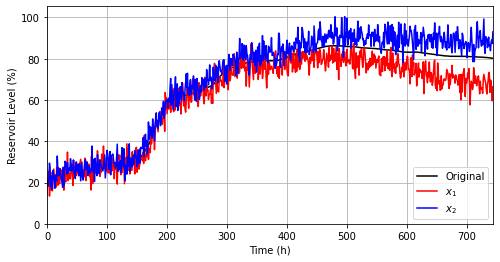

In [21]:
# 1 = Hidroeletric data
if DataSet == 1:
  Y0 = [20.46, 20.61, 20.75, 20.9, 21.02, 21.14, 21.29, 21.43, 21.58, 21.73, 21.88, 21.97, 22.12, 22.27, 22.36, 22.45, 22.54, 22.63, 22.75, 22.87, 22.96, 23.04, 23.13, 23.22, 23.34, 23.43, 23.52, 23.61, 23.7, 23.8, 23.89, 23.98, 24.07, 24.16, 24.22, 24.28, 24.34, 24.4, 24.46, 24.52, 24.61, 24.7, 24.82, 24.91, 24.97, 25.03, 25.09, 25.15, 25.21, 25.27, 25.33, 25.4, 25.46, 25.52, 25.58, 25.64, 25.7, 25.76, 25.82, 25.85, 25.85, 25.88, 25.94, 26.00, 26.06, 26.12, 26.19, 26.25, 26.28, 26.31, 26.34, 26.37, 26.4, 26.46, 26.49, 26.52, 26.58, 26.61, 26.64, 26.67, 26.7, 26.73, 26.76, 26.8, 26.83, 26.86, 26.89, 26.92, 26.95, 26.98, 27.01, 27.04, 27.1, 27.16, 27.19, 27.22, 27.25, 27.32, 27.35, 27.38, 27.41, 27.44, 27.47, 27.5, 27.53, 27.56, 27.59, 27.62, 27.68, 27.71, 27.74, 27.74, 27.78, 27.81, 27.84, 27.87, 27.9, 27.93, 27.96, 27.99, 28.02, 28.05, 28.08, 28.11, 28.11, 28.14, 28.21, 28.3, 28.42, 28.61, 28.76, 28.91, 29.07, 29.19, 29.32, 29.47, 29.59, 29.72, 29.84, 29.97, 30.09, 30.22, 30.34, 30.46, 30.59, 30.71, 30.84, 30.96, 31.09, 31.21, 31.31, 31.4, 31.49, 31.62, 31.81, 31.99, 32.31, 32.65, 33.06, 33.47, 33.85, 34.23, 34.71, 35.22, 35.63, 36.18, 36.66, 37.14, 37.69, 38.24, 38.82, 39.4, 40.05, 40.8, 41.56, 42.41, 43.14, 43.93, 44.87, 45.63, 46.27, 46.97, 47.65, 48.36, 49.00, 49.58, 50.16, 50.74, 51.32, 51.9, 52.49, 53.01, 53.53, 53.98, 54.46, 54.91, 55.3, 55.72, 56.03, 56.45, 56.77, 57.12, 57.36, 57.64, 57.89, 58.17, 58.42, 58.6, 58.81, 59.05, 59.23, 59.44, 59.59, 59.8, 59.98, 60.15, 60.3, 60.51, 60.72, 60.9, 61.08, 61.22, 61.37, 61.51, 61.62, 61.69, 61.8, 61.9, 62.01, 62.08, 62.15, 62.22, 62.33, 62.44, 62.55, 62.66, 62.73, 62.8, 62.83, 62.87, 62.94, 63.09, 63.19, 63.3, 63.48, 63.59, 63.7, 63.81, 63.91, 64.02, 64.13, 64.28, 64.42, 64.49, 64.57, 64.64, 64.71, 64.75, 64.82, 64.93, 65.04, 65.18, 65.33, 65.43, 65.54, 65.69, 65.8, 65.91, 66.05, 66.2, 66.34, 66.49, 66.63, 66.78, 66.93, 67.11, 67.29, 67.47, 67.73, 68.02, 68.46, 68.87, 69.27, 69.6, 69.97, 70.34, 70.71, 71.08, 71.38, 71.68, 71.97, 72.23, 72.49, 72.76, 73.02, 73.28, 73.43, 73.61, 73.84, 74.03, 74.25, 74.48, 74.7, 74.89, 75.08, 75.27, 75.45, 75.57, 75.68, 75.79, 75.91, 75.98, 76.09, 76.25, 76.4, 76.55, 76.66, 76.77, 76.85, 76.93, 77.00, 77.08, 77.15, 77.23, 77.3, 77.38, 77.46, 77.53, 77.61, 77.68, 77.76, 77.84, 77.91, 78.06, 78.14, 78.22, 78.25, 78.29, 78.33, 78.37, 78.37, 78.41, 78.41, 78.44, 78.48, 78.52, 78.56, 78.6, 78.6, 78.63, 78.63, 78.67, 78.67, 78.67, 78.71, 78.75, 78.75, 78.79, 78.82, 78.86, 78.9, 78.94, 78.94, 78.94, 78.94, 78.94, 78.94, 78.94, 78.94, 78.94, 78.98, 78.98, 78.98, 78.98, 78.98, 78.98, 78.98, 78.98, 78.98, 78.98, 79.01, 79.05, 79.09, 79.13, 79.17, 79.21, 79.28, 79.32, 79.4, 79.47, 79.63, 79.74, 79.85, 79.97, 80.08, 80.2, 80.28, 80.35, 80.47, 80.58, 80.7, 80.77, 80.89, 81.00, 81.12, 81.2, 81.27, 81.35, 81.43, 81.5, 81.62, 81.77, 81.93, 82.08, 82.23, 82.35, 82.43, 82.47, 82.54, 82.58, 82.66, 82.7, 82.77, 82.81, 82.85, 82.93, 82.97, 83.01, 83.08, 83.12, 83.16, 83.2, 83.28, 83.35, 83.47, 83.63, 83.7, 83.78, 83.82, 83.86, 83.94, 84.01, 84.09, 84.17, 84.28, 84.36, 84.48, 84.6, 84.71, 84.83, 84.87, 84.91, 84.98, 85.06, 85.14, 85.22, 85.3, 85.37, 85.45, 85.53, 85.61, 85.68, 85.76, 85.84, 85.92, 85.96, 86.00, 86.07, 86.11, 86.15, 86.19, 86.23, 86.27, 86.27, 86.27, 86.27, 86.27, 86.27, 86.27, 86.27, 86.27, 86.27, 86.23, 86.23, 86.23, 86.23, 86.23, 86.23, 86.23, 86.19, 86.15, 86.11, 86.07, 86.04, 86.00, 85.96, 85.92, 85.92, 85.92, 85.92, 85.92, 85.92, 85.88, 85.88, 85.88, 85.84, 85.84, 85.84, 85.84, 85.8, 85.8, 85.8, 85.76, 85.72, 85.68, 85.65, 85.61, 85.57, 85.53, 85.49, 85.45, 85.41, 85.37, 85.33, 85.3, 85.3, 85.3, 85.26, 85.26, 85.22, 85.22, 85.18, 85.18, 85.14, 85.14, 85.1, 85.1, 85.06, 85.06, 85.02, 85.02, 84.98, 84.98, 84.94, 84.94, 84.94, 84.91, 84.91, 84.87, 84.87, 84.83, 84.79, 84.75, 84.71, 84.67, 84.63, 84.6, 84.56, 84.52, 84.48, 84.44, 84.4, 84.36, 84.32, 84.28, 84.25, 84.25, 84.25, 84.21, 84.21, 84.21, 84.17, 84.17, 84.13, 84.13, 84.09, 84.05, 84.05, 84.01, 83.97, 83.94, 83.9, 83.86, 83.82, 83.74, 83.7, 83.66, 83.59, 83.51, 83.43, 83.39, 83.35, 83.32, 83.28, 83.24, 83.24, 83.2, 83.2, 83.2, 83.2, 83.16, 83.16, 83.16, 83.12, 83.12, 83.12, 83.08, 83.08, 83.12, 83.12, 83.12, 83.16, 83.16, 83.2, 83.2, 83.2, 83.2, 83.16, 83.12, 83.08, 83.05, 82.97, 82.93, 82.89, 82.85, 82.81, 82.77, 82.74, 82.7, 82.66, 82.62, 82.58, 82.54, 82.5, 82.47, 82.43, 82.39, 82.35, 82.31, 82.27, 82.23, 82.2, 82.16, 82.12, 82.08, 82.04, 82.00, 81.97, 81.93, 81.89, 81.85, 81.81, 81.77, 81.73, 81.7, 81.66, 81.58, 81.54, 81.5, 81.46, 81.43, 81.39, 81.39, 81.35, 81.35, 81.35, 81.31, 81.31, 81.27, 81.27, 81.23, 81.2, 81.16, 81.16, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.12, 81.08, 81.08, 81.08, 81.04, 81.00, 81.00, 81.00, 80.97, 80.97, 80.97, 80.93, 80.93, 80.93, 80.89, 80.89, 80.89, 80.85, 80.85, 80.81, 80.81, 80.77, 80.77, 80.74, 80.74, 80.74, 80.7, 80.7, 80.7, 80.66, 80.66, 80.62, 80.62, 80.58, 80.58, 80.54, 80.51, 80.51, 80.47, 80.43, 80.39, 80.35, 80.31, 80.28, 80.24, 80.2]  
  length = len(Y0)
  # Include Noice
  noice = 4
  t = np.linspace(0, 50*np.pi, length)
  x1 = Y0 - 0.0005*(t**2) + np.random.normal(0, noice, length)
  x2 = Y0 + 0.05*t + np.random.normal(0, noice, length)
  
  plt.figure(figsize=(8, 4))
  plt.plot(range(len(x1)), Y0, 'k', label='Original')
  plt.plot(range(len(x1)), x1, 'r', label='$x_1$')
  plt.plot(range(len(x2)), x2, 'b', label='$x_2$')
  plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
  plt.axis([0, len(x1), 0, max(x2)+5])
  plt.xlabel('Time (h)')
  plt.ylabel('Reservoir Level (%)')
  plt.grid()
  # plt.savefig('Singals.pdf')
  plt.show()

# Wavelet

/usr/local/lib/python3.9/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

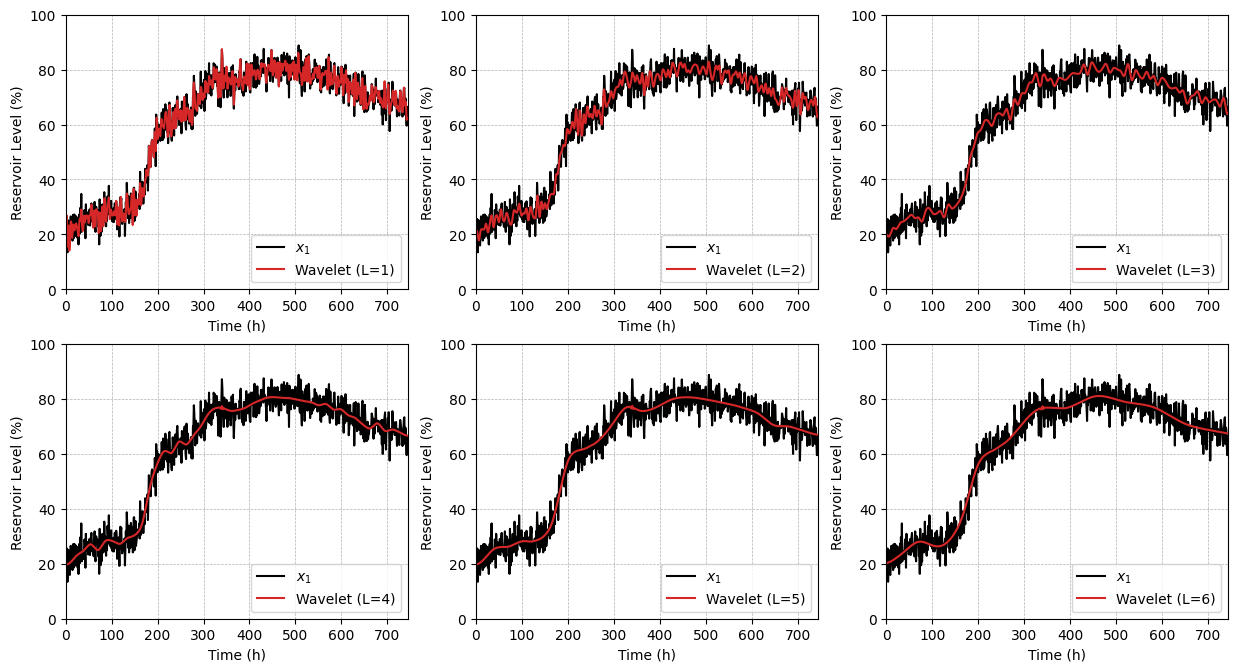

In [22]:
# Method: {'BayesShrink', 'VisuShrink'}
# Thresholding method to be used. The currently supported methods are "BayesShrink" and "VisuShrink".

# Mode: {'soft', 'hard'}
# An optional argument to choose the type of denoising performed. It noted that choosing soft thresholding given additive noise finds the best approximation of the original image.

# Wavelet_levels: {int}
# The number of wavelet decomposition levels to use. The default is three less than the maximum number of possible decomposition levels.

# Wavelet: {string}
# The type of wavelet to perform and can be any of the options pywt.wavelist outputs. 
# Wavelet can be any of {'db2', 'db1', 'haar', 'sym9', 'sym8'} and many more.

# Wavelet denoising
x_denoise1 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
x_denoise2 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=2, wavelet='sym8', rescale_sigma='True')
x_denoise3 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')
x_denoise4 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=4, wavelet='sym8', rescale_sigma='True')
x_denoise5 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=5, wavelet='sym8', rescale_sigma='True')
x_denoise6 = denoise_wavelet(x1, method='VisuShrink', mode='soft', wavelet_levels=6, wavelet='sym8', rescale_sigma='True')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8), dpi=100)

ax1.plot(x1,'k', zorder=2)
ax1.plot(x_denoise1,'tab:red', zorder=2)
ax1.set_ylabel('Reservoir Level (%)')
ax1.set_xlabel('Time (h)')
ax1.axis([0, len(x1), 0, 100])
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(["$x_1$", "Wavelet (L=1)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show    

ax2.plot(x1,'k', zorder=2)
ax2.plot(x_denoise2,'tab:red', zorder=2)
ax2.set_ylabel('Reservoir Level (%)')
ax2.set_xlabel('Time (h)')
ax2.axis([0, len(x1), 0, 100])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(["$x_1$", "Wavelet (L=2)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show

ax3.plot(x1,'k', zorder=2)
ax3.plot(x_denoise3,'tab:red', zorder=2)
ax3.set_ylabel('Reservoir Level (%)')
ax3.set_xlabel('Time (h)')
ax3.axis([0, len(x1), 0, 100])
ax3.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax3.legend(["$x_1$", "Wavelet (L=3)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show  

ax4.plot(x1,'k', zorder=2)
ax4.plot(x_denoise4,'tab:red', zorder=2)
ax4.set_ylabel('Reservoir Level (%)')
ax4.set_xlabel('Time (h)')
ax4.axis([0, len(x1), 0, 100])
ax4.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax4.legend(["$x_1$", "Wavelet (L=4)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show  

ax5.plot(x1,'k', zorder=2)
ax5.plot(x_denoise5,'tab:red', zorder=2)
ax5.set_ylabel('Reservoir Level (%)')
ax5.set_xlabel('Time (h)')
ax5.axis([0, len(x1), 0, 100])
ax5.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax5.legend(["$x_1$", "Wavelet (L=5)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show  

ax6.plot(x1,'k', zorder=2)
ax6.plot(x_denoise6,'tab:red', zorder=2)
ax6.set_ylabel('Reservoir Level (%)')
ax6.set_xlabel('Time (h)')
ax6.axis([0, len(x1), 0, 100])
ax6.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax6.legend(["$x_1$", "Wavelet (L=6)"], loc='lower right', fancybox=True, shadow=False, ncol=1)
# plt.savefig('Wavelet.pdf')
plt.show  

In [23]:
# Use the best wavelet found
x1_d = denoise_wavelet(x1, method='BayesShrink', mode='soft', wavelet_levels=6, wavelet='sym8', rescale_sigma='True')
x2_d = denoise_wavelet(x2, method='BayesShrink', mode='soft', wavelet_levels=6, wavelet='sym8', rescale_sigma='True')

# Definition if the wavelet is used 
if WaveletUse == 1:
  x1 = x1_d
  x2 = x2_d

interval columns not set, guessing: ['x$_1$', 'x$_2$']


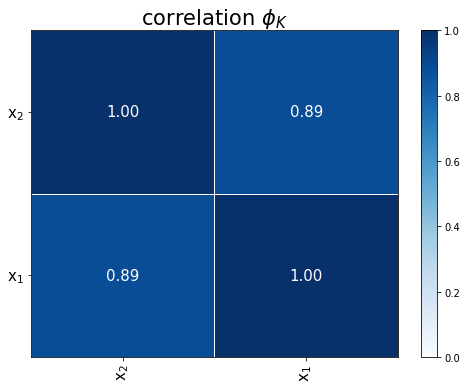

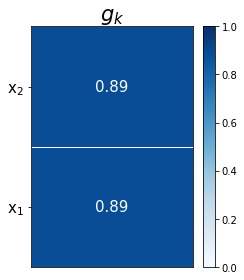

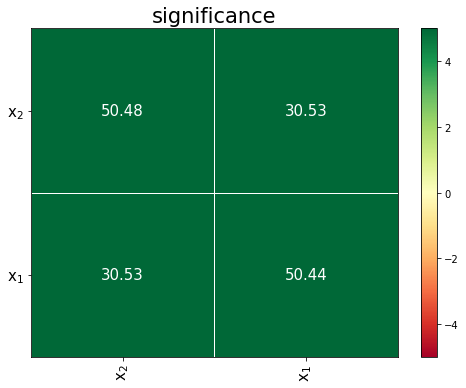

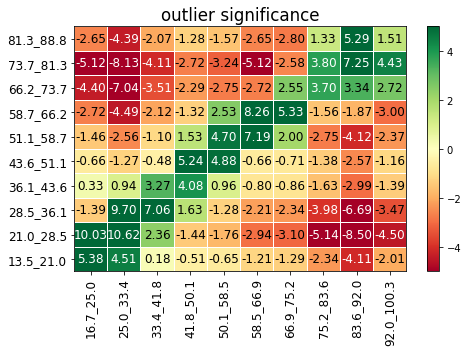

(          x$_1$     x$_2$
 x$_1$  1.000000  0.886953
 x$_2$  0.886953  1.000000, array([[0.88695287],
        [0.88695287]]),            x$_1$      x$_2$
 x$_1$  50.443443  30.526861
 x$_2$  30.526861  50.484363, {'x$_1$:x$_2$':            16.7_25.0  25.0_33.4  33.4_41.8  41.8_50.1  50.1_58.5  58.5_66.9  \
  13.5_21.0   5.383320   4.512496   0.181964  -0.511046  -0.650830  -1.209693   
  21.0_28.5  10.025186  10.619890   2.357245  -1.444005  -1.761835  -2.935104   
  28.5_36.1  -1.394989   9.695897   7.059077   1.632764  -1.284256  -2.211564   
  36.1_43.6   0.332876   0.937757   3.267618   4.078193   0.958535  -0.800974   
  43.6_51.1  -0.659405  -1.274903  -0.475170   5.237843   4.876438  -0.659405   
  51.1_58.7  -1.456043  -2.562371  -1.098250   1.529936   4.698635   7.188366   
  58.7_66.2  -2.715619  -4.493741  -2.122942  -1.319383   2.528628   8.255643   
  66.2_73.7  -4.398551  -7.036876  -3.512582  -2.292447  -2.746866  -2.716450   
  73.7_81.3  -5.119074  -8.125891  -4.10957

In [24]:
# Evaluation of the correlation of the series
dfphi = pd.DataFrame({'x$_1$': x1, 'x$_2$': x2})

# Generating the report
report.correlation_report(dfphi, pdf_file_name='report_original.pdf')

# Organize the Data

In [25]:
# Define the train ratio
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
x_index = np.array(range(len(t)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)

if DataSet == 1:
  x1_trend = 1.01*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
  x2_trend = 0.86*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]

if DataSet == 2:
  x1_trend = 0.05*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
  x2_trend = 1.5*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]

if DataSet == 3:
  x1_trend = -0.1*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
  x2_trend = 1*(x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]

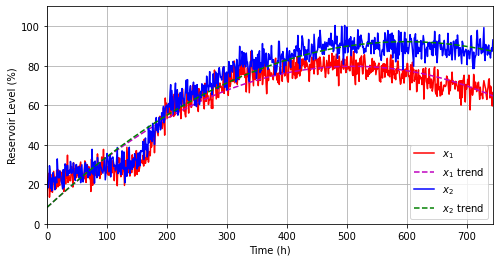

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(x1)), x1, 'r', label='$x_1$')
plt.plot(range(len(x1_trend)), x1_trend, 'm', linestyle='--', label='$x_1$ trend')
plt.plot(range(len(x2)), x2, 'b', label='$x_2$')
plt.plot(range(len(x2_trend)), x2_trend, 'g', linestyle='--', label='$x_2$ trend')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.axis([0, len(x1), 0, 110])
plt.xlabel('Time (h)')
plt.ylabel('Reservoir Level (%)')
plt.grid()
# plt.savefig('1.pdf')
plt.show()

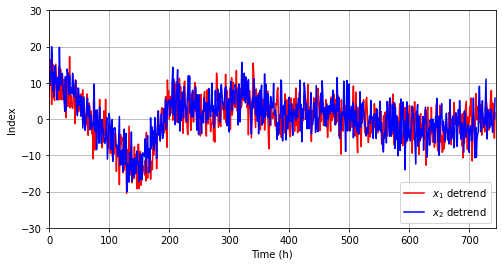

In [27]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(8, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, 'r', label='$x_1$ detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, 'b', label='$x_2$ detrend')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.axis([0, len(x1), -30, 30])
plt.xlabel('Time (h)')
plt.ylabel('Index')
plt.grid()
# plt.savefig('2.pdf')
plt.show()

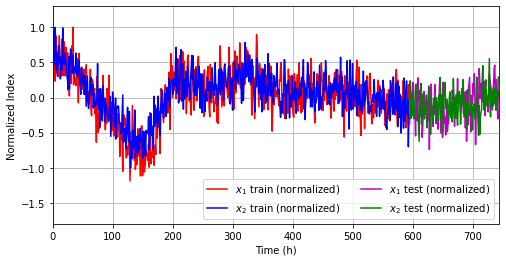

In [28]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])

x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns

x_normalize = np.divide(x_lbl, x_train_max)

plt.figure(figsize=(8, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], 'r', label='$x_1$ train (normalized)')
plt.plot(range(train_len), x_normalize[:train_len, 1], 'b', label='$x_2$ train (normalized)')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], 'm', label='$x_1$ test (normalized)')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], 'g', label='$x_2$ test (normalized)')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=2)
plt.axis([0, len(x1), -1.8, 1.3])
plt.xlabel('Time (h)')
plt.ylabel('Normalized Index')
plt.grid()
# plt.savefig('3.pdf')
plt.show()

In [29]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(525, 200, 3) (525, 20, 3) (525,)
(395, 200, 3) (395, 20, 3)
(130, 200, 3) (130, 20, 3)


# Model 1: Simple Seq2Seq LSTM Model

In [30]:
n_hidden = 25

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_sequences=False, return_state=True)(input_train)
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1) # Adam, RMSprop, SGD
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
# model.summary()

# Evaluate the time for training the model
inicio = time.time()

# To save values for statistics
MSE=[]
MAE=[]
MAPE=[]

for i in range(Experiments):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=100)

  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']

  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
  test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
  train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
  test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]

  train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
  train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)

  data_final = dict()
  for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                    ['train_pred', 'train_true', 'test_pred', 'test_true']):
      dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
      dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
      data_final[lb] = np.concatenate(
          [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)

  for lb in ['train', 'test']:
      MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
      MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
  ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
  train_start_t = 0
  test_start_t = data_final['train_pred'].shape[0]
  
  print(f'Simulation: {i+1}')
  print('\n')
  MSE.append(mse[len(mse)-1])
  MAE.append(mae[len(mse)-1])
  MAPE.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio
print('Time: {:.2f}s'.format(time_s))

Epoch 1/100
4/4 [==============================] - 21s 1s/step - loss: 0.1477 - mse: 0.1477 - mae: 0.2887 - mape: 366.3036 - val_loss: 0.0530 - val_mse: 0.0530 - val_mae: 0.1875 - val_mape: 117.5558
Epoch 2/100
4/4 [==============================] - 2s 510ms/step - loss: 0.0888 - mse: 0.0888 - mae: 0.2308 - mape: 307.8735 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1857 - val_mape: 118.9349
Epoch 3/100
4/4 [==============================] - 2s 532ms/step - loss: 0.0731 - mse: 0.0731 - mae: 0.2133 - mape: 325.8767 - val_loss: 0.0541 - val_mse: 0.0541 - val_mae: 0.1895 - val_mape: 134.9808
Epoch 4/100
4/4 [==============================] - 2s 511ms/step - loss: 0.0667 - mse: 0.0667 - mae: 0.2035 - mape: 318.3345 - val_loss: 0.0719 - val_mse: 0.0719 - val_mae: 0.2152 - val_mape: 184.2393
Epoch 5/100
4/4 [==============================] - 3s 872ms/step - loss: 0.0630 - mse: 0.0630 - mae: 0.1989 - mape: 298.2882 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2352 - val_mape: 217.29

In [31]:
plot_model(model, to_file='model_plot.pdf', show_shapes=True, show_layer_names=True)

## Plots

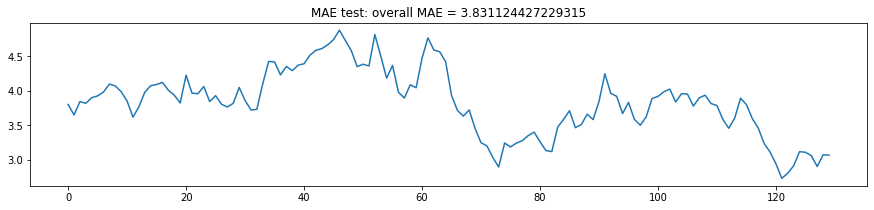

In [32]:
for lb in ['test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    # plt.savefig('4.pdf')
    plt.show()

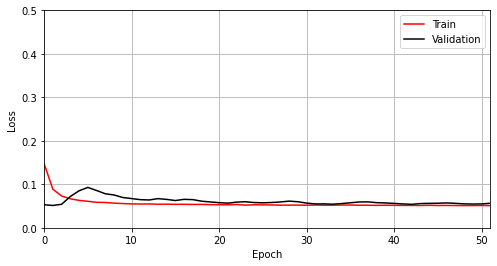

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, 'r', label='Train'), 
plt.plot(valid_loss, 'k', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right', fancybox=True, shadow=False, ncol=1)
plt.axis([0, len(train_loss)-1, 0, 0.5])
plt.grid()
# plt.savefig('5.pdf')
plt.show()

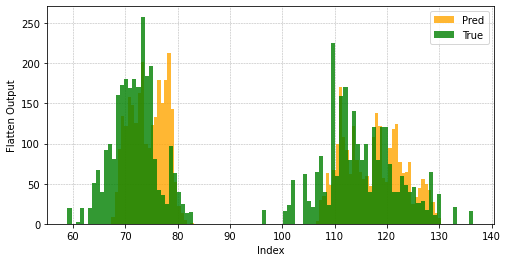

In [34]:
for lb in ['test']:
    plt.figure(figsize=(8, 4))
    plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.8, label='Pred', zorder=2)
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.8, label='True', zorder=2)
    plt.legend(loc='upper right', fancybox=True, shadow=False, ncol=1)
    plt.ylabel('Flatten Output')
    plt.xlabel('Index')
    plt.legend()
    # plt.title('value distribution: '+lb)
    # plt.savefig('6.pdf')
    plt.show()

# Model 2: Seq2Seq LSTM Model with Luong Attention

In [35]:
n_hidden = 25

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
# model.summary()

# Evaluate the time for training the model
inicio = time.time()

# To save values for statistics
MSE_A=[]
MAE_A=[]
MAPE_A=[]

for i in range(Experiments):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=100)

  train_mae = history.history['mae']
  valid_mae = history.history['val_mae']
  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
  test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
  train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
  test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]

  train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
  train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)

  data_final = dict()
  for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                    ['train_pred', 'train_true', 'test_pred', 'test_true']):
      dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
      dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
      data_final[lb] = np.concatenate(
          [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)

  for lb in ['train', 'test']:
      MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
      MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
  ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
  train_start_t = 0
  test_start_t = data_final['train_pred'].shape[0]

  print(f'Simulation: {i+1}')
  print('\n')
  MSE_A.append(mse[len(mse)-1])
  MAE_A.append(mae[len(mse)-1])
  MAPE_A.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio
print('Time: {:.2f}s'.format(time_s))

Epoch 1/100
4/4 [==============================] - 17s 1s/step - loss: 0.1404 - mse: 0.1404 - mae: 0.2946 - mape: 558.3385 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1841 - val_mape: 111.8218
Epoch 2/100
4/4 [==============================] - 3s 795ms/step - loss: 0.0737 - mse: 0.0737 - mae: 0.2163 - mape: 323.4935 - val_loss: 0.0764 - val_mse: 0.0764 - val_mae: 0.2267 - val_mape: 206.1365
Epoch 3/100
4/4 [==============================] - 3s 621ms/step - loss: 0.0754 - mse: 0.0754 - mae: 0.2210 - mape: 394.4469 - val_loss: 0.1474 - val_mse: 0.1474 - val_mae: 0.3232 - val_mape: 370.3000
Epoch 4/100
4/4 [==============================] - 2s 554ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.2067 - mape: 401.4152 - val_loss: 0.1558 - val_mse: 0.1558 - val_mae: 0.3305 - val_mape: 366.2280
Epoch 5/100
4/4 [==============================] - 2s 591ms/step - loss: 0.0619 - mse: 0.0619 - mae: 0.1980 - mape: 380.4155 - val_loss: 0.1404 - val_mse: 0.1404 - val_mae: 0.3096 - val_mape: 327.24

In [36]:
plot_model(model, to_file='model_plot_attention.pdf', show_shapes=True, show_layer_names=True)

## Plots

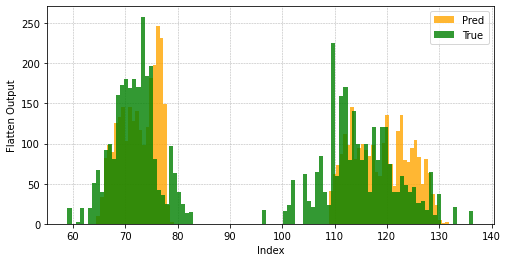

In [37]:
for lb in ['test']:
    plt.figure(figsize=(8, 4))
    plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.8, label='Pred', zorder=2)
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.8, label='True', zorder=2)
    plt.legend(loc='upper right', fancybox=True, shadow=False, ncol=1)
    plt.ylabel('Flatten Output')
    plt.xlabel('Index')
    # plt.title('value distribution: '+lb)
    # plt.savefig('7.pdf')
    plt.show()

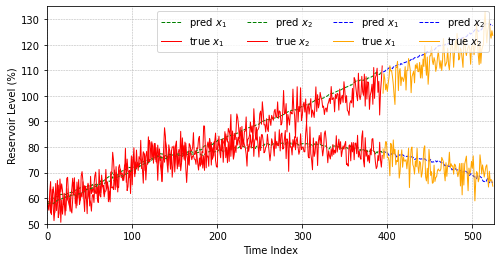

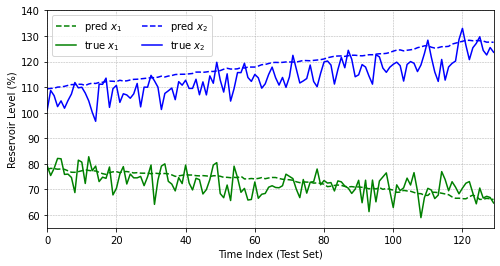

In [38]:
  for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                    ['train_pred', 'train_true', 'test_pred', 'test_true']):
      dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
      dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
      data_final[lb] = np.concatenate([np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)

  for lb in ['train', 'test']:
      MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
      MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
  ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
  plt.figure(figsize=(8, 4))
  plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
  train_start_t = 0
  test_start_t = data_final['train_pred'].shape[0]
  for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
      for i, x_lbl in zip([0, 1], ['$x_1$', '$x_2$']):
          plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), data_final[lb+'_pred'][:, ith_timestep, i], 
                   linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
          plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                  data_final[lb+'_true'][:, ith_timestep, i], 
                  linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
      
  #plt.title('{}th time step in all samples'.format(ith_timestep))
  plt.legend(loc='upper right', fancybox=True, shadow=False, ncol=4)
  plt.axis([0, tm+data_final[lb+'_pred'].shape[0], 50, 135])
  plt.xlabel('Time Index')
  plt.ylabel('Reservoir Level (%)')
  plt.savefig('8.pdf')
  plt.show()

  lb = 'test'
  plt.figure(figsize=(8, 4))
  plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
  for i, x_lbl, clr in zip([0, 1], ['$x_1$', '$x_2$'], ['green', 'blue']):
      plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
      plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
  plt.legend(loc='upper left', fancybox=True, shadow=False, ncol=2)
  plt.axis([0, (len(data_final[lb+'_true'][:, ith_timestep, i]))-1, 55, 140])
  plt.xlabel('Time Index (Test Set)')
  plt.ylabel('Reservoir Level (%)')
  # plt.savefig('9.pdf')
  plt.show()